# Implement a simple Transformer

This notebook implement a simple transformer model, trained on a randomly generated time series data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Generate synthetic time series data
def generate_time_series(n_samples, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, n_samples, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(n_samples, n_steps) - 0.5)
    return series.astype(np.float32)

# Create a transformer-based model
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, n_layers, n_heads, hidden_size, dropout):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(
            d_model=input_size,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
        )
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.transformer(x, x)
        x = self.fc(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Prepare data
n_samples = 1000
n_steps = 513
series = generate_time_series(n_samples, n_steps)
scaler = StandardScaler()
series_scaled = scaler.fit_transform(series.T).T
X = series_scaled[:, :n_steps-1]
y = series_scaled[:, 1:]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [5]:
# Initialize model
input_size = 512
output_size = 512
n_layers = 2
n_heads = 4
hidden_size = 32
dropout = 0.1
model = TransformerModel(input_size, output_size, n_layers, n_heads, hidden_size, dropout).to(device)


# Convert data to the appropriate device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 200
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}")

/root/miniconda3/envs/torch210/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/root/miniconda3/envs/torch210/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/200], Loss: 1.2826976776123047
Epoch [2/200], Loss: 1.0116225481033325
Epoch [3/200], Loss: 0.635532021522522
Epoch [4/200], Loss: 0.4489162862300873
Epoch [5/200], Loss: 0.35763952136039734
Epoch [6/200], Loss: 0.2987120449542999
Epoch [7/200], Loss: 0.30284008383750916
Epoch [8/200], Loss: 0.2880264222621918
Epoch [9/200], Loss: 0.29169321060180664
Epoch [10/200], Loss: 0.2669679522514343
Epoch [11/200], Loss: 0.2674340307712555
Epoch [12/200], Loss: 0.25883418321609497
Epoch [13/200], Loss: 0.23866242170333862
Epoch [14/200], Loss: 0.21799877285957336
Epoch [15/200], Loss: 0.20396709442138672
Epoch [16/200], Loss: 0.19301307201385498
Epoch [17/200], Loss: 0.17444251477718353
Epoch [18/200], Loss: 0.16921290755271912
Epoch [19/200], Loss: 0.1575583964586258
Epoch [20/200], Loss: 0.14533430337905884
Epoch [21/200], Loss: 0.1386234015226364
Epoch [22/200], Loss: 0.12826502323150635
Epoch [23/200], Loss: 0.11779733747243881
Epoch [24/200], Loss: 0.11164677143096924
Epoch [25/20

In [6]:
# Evaluate the model
with torch.no_grad():
    model.eval()
    y_pred_test = model(X_test_tensor)
    y_pred_test = y_pred_test.cpu()
    mse = mean_squared_error(y_test, y_pred_test)
    print(f"Test MSE: {mse}")

Test MSE: 0.009519089013338089


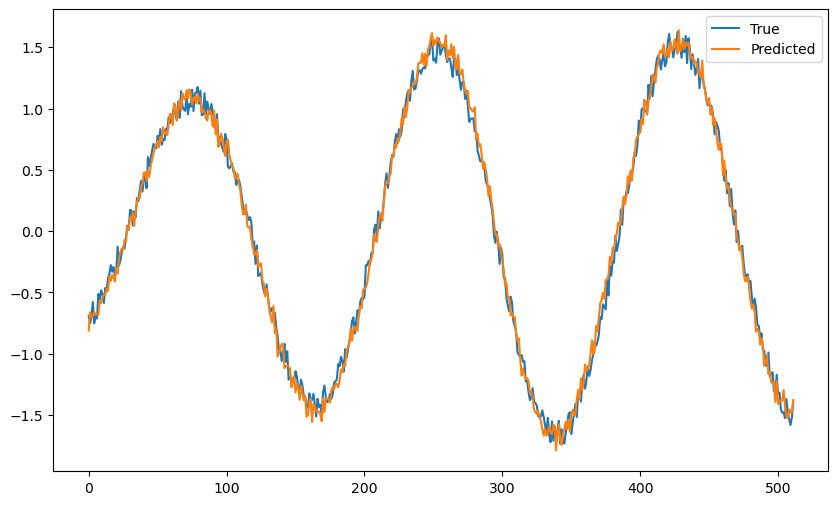

In [7]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label="True")
plt.plot(y_pred_test[0], label="Predicted")
plt.legend()
plt.show()

## Comment

Result over-fit, but it works.